# HPV Risk Modelling on Real-World Healthcare Data

## Project Overview
This project focuses on building an applied analytical pipeline for HPV risk modelling
using real-world healthcare and lifestyle data.

The dataset reflects realistic challenges commonly encountered in healthcare analytics,
including class imbalance, missing values, noisy features, and limited sample size.
Rather than optimising for maximum model performance, the goal is to develop a
transparent and decision-aware modelling process.

## Objective
The primary objective of this project is to demonstrate how meaningful analytical
insights and usable risk models can be developed despite significant data limitations.

The emphasis is placed on:
- Data cleaning and quality assessment
- Exploratory data analysis to understand bias and structure
- Feature selection and reduction of noise
- Handling class imbalance and tuning decision thresholds
- Interpreting model outputs and clearly defining limitations

## Dataset Description
The dataset contains anonymised patient-level lifestyle and health-related variables
used to assess HPV infection risk. The target variable represents HPV infection status,
with a strong imbalance between positive and negative cases.

All modelling decisions are made with explicit acknowledgment of data quality issues
and domain constraints.


## Liberaries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler

#Metrics libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

## Reading Data

In [2]:
data = pd.read_excel(r"E:\Project\GITHub\Project02\RawData.xlsx")
data.head()

,DNA Sample I.D.,Age,Gender,Ethnicity,Currently Smoke?,Current Smoking Frequency,Current Smoking Amount,Years Smoked,Current Other Substances [O],Current Smoking Frequency [O],...,Years Since Diagnosis (From Collection),HPV Cancer and/or Precursor?,HPV Cancer and/or Precursor DIAGNOSIS,HPV Vaccination?,Via Which Healthcare Service?,Overall HPV Positive?,HPV16 Positive?,HPV18 Positive?,HPV6 Positive?,HPV11 Positive?
0,D1,18-25,F,White British,No,NaN,NaN,NaN,NaN,NaN,...,NaN,N,NaN,Y,NHS,N,NaN,NaN,NaN,NaN
1,D2,18-25,F,White British,No,NaN,NaN,NaN,NaN,NaN,...,NaN,N,NaN,N,NaN,N,NaN,NaN,NaN,NaN
2,D3,18-25,F,White British,No,NaN,NaN,NaN,NaN,NaN,...,NaN,N,NaN,Y,NHS,N,NaN,NaN,NaN,NaN
3,D4,18-25,M,White British,No,NaN,NaN,NaN,NaN,NaN,...,NaN,N,NaN,N,NaN,Unknown,NaN,NaN,NaN,NaN
4,D5,18-25,F,White British,No,NaN,NaN,NaN,NaN,NaN,...,NaN,N,NaN,Y,NHS,N,N,N,N,N


## Data Cleaning

This dataset is real world and messy, so data cleaning is not optional.  
Before any modelling, we need to make the columns consistent, fix mixed data types, and handle missing values properly.

Key data quality issues observed:
- Inconsistent column names (spaces, punctuation, brackets, hidden suffixes like `[0]`, duplicated naming patterns)
- Mixed formats in several fields (numeric, text, ranges like `18-25`, and blank values)
- Many missing values in lifestyle variables (smoking, substances, frequency, amount)
- Some columns behave like dates or durations but are stored as text
- Target related fields can be confusing (multiple HPV outcome columns), so we will define one clear target later

In this section we standardise headers first, then clean the most problematic fields (age and date or duration style columns).

---

### Rename Columns

We rename columns to a consistent machine friendly format so that:
- feature selection and modelling code stays stable
- column referencing is simple and typo resistant
- duplicate or messy headers do not break the pipeline

Approach:
- remove brackets like `[0]`
- remove punctuation and extra spaces
- convert to snake_case
- ensure unique names if duplicates exist


In [3]:
import re
# Clean headers
cleaned_columns = []
for column in data.columns:
    cleaned_column = re.sub(r'\W+', '', column)
    cleaned_column = re.sub(r'[Oo0]+$', '', cleaned_column)
    cleaned_columns.append(cleaned_column)

data.columns = cleaned_columns

# Display the list of cleaned header names
header_names = data.columns.tolist()
print(header_names)

['DNASampleID', 'Age', 'Gender', 'Ethnicity', 'CurrentlySmoke', 'CurrentSmokingFrequency', 'CurrentSmokingAmount', 'YearsSmoked', 'CurrentOtherSubstances', 'CurrentSmokingFrequency', 'CurrentSmokingAmount', 'YearsSmoked', 'PreviouslySmoke', 'PreviousSmokingFrequency', 'PreviousSmokingAmount', 'YearsSmoked1', 'PreviousOtherSubstances', 'PreviousSmokingFrequency', 'PreviousSmokingAmount', 'YearsSmokedO1', 'CurrentlyDrink', 'CurrentDrinkingFrequency', 'CurrentAlcoholTypes', 'CurrentDrinkingAmountUnits', 'PreviouslyDrank', 'PreviousDrinkingFrequency', 'PreviousAlcoholTypes', 'PreviousDrinkingAmountUnits', 'OpenmouthKissing', 'SexualOrientation', 'RelationshipStatus', 'RelationshipLengthMonths', 'MonogamyinRelationship', 'SexualIntercourseWithinTheLastYear', 'NoofLifetimeSexualPartners', 'TypesofSexualActivity', 'STISTDStatus', 'STISTDType', 'CurrentCondomUseFrequencyScale', 'CUFIfNeverWhy', 'OneNightStands', 'DiagnosedHPVInfection', 'YearsSinceDiagnosisFromCollection', 'HPVCancerandorPrecu

### Remove high missing columns

This dataset contains a large amount of missing values across multiple questionnaire style fields. To keep the modelling pipeline stable and reduce noise, we drop columns with more than 100 missing values. Given the dataset size, this is roughly equivalent to removing columns with more than about 23 percent missingness.


In [4]:
# Calculate missing values per column
missing_count = data.isna().sum()

# Define threshold used in the report
missing_threshold = 100

# Select columns to drop based on missingness
cols_to_drop_missing = missing_count[missing_count > missing_threshold].index.tolist()

# Drop high missing columns
data = data.drop(columns=cols_to_drop_missing)

# Quick check
print(f"Rows: {data.shape[0]}")
print(f"Columns after dropping high missing: {data.shape[1]}")
print(f"Dropped columns (missing > {missing_threshold}): {len(cols_to_drop_missing)}")


Rows: 438
Columns after dropping high missing: 20
Dropped columns (missing > 100): 32


---

### Target variable preparation

Rows with unknown HPV status were removed to ensure a supervised learning setup. The target variable was then encoded into a binary numerical format suitable for modelling.


In [5]:
# Start from the original dataframe
df = data.copy()

# Remove samples with 'Unknown'
df = df[df['OverallHPVPositive'] != 'Unknown'].copy()

# Map 'N' → 0 and 'Y' → 1
target_mapping = {
    'N': 0,
    'Y': 1
}

df['OverallHPVPositive'] = df['OverallHPVPositive'].map(target_mapping)

# Sanity check
print("Class distribution after mapping:")
print(df['OverallHPVPositive'].value_counts())

print("\nNumber of NaN values after mapping:")
print(df['OverallHPVPositive'].isna().sum())

Class distribution after mapping:
OverallHPVPositive
0    315
1     93
Name: count, dtype: int64

Number of NaN values after mapping:
0


In [6]:
# Define the file path (must include file name)
file_path = r"E:\Project\GITHUB\Project02\data_cleaned.xlsx"

# Create final copy for export
df_final = df.copy()

# Save the DataFrame to Excel
df_final.to_excel(file_path, index=False)

# Confirmation message
print("Data exported successfully.")


Data exported successfully.


---

## Multi label categorical features: vectorised encoding

Several columns store multiple categorical values as coded strings separated by delimiters. To ensure consistency, scalability, and modelling readiness, a reusable vectorised encoding pattern is applied across all multi label features using mapping dictionaries and one hot encoding.

In [7]:
# Mapping for alcohol types
alcohol_map = {
    "1": "no_drinking",
    "2": "beer_ale",
    "3": "wine",
    "4": "lager",
    "5": "neat_spirits",
    "6": "spirits_with_mixer",
    "7": "cider",
    "8": "other"
}

# Mapping for sexual activity types
sexual_activity_map = {
    "1": "vaginal_sex",
    "2": "anal_sex",
    "3": "oral_sex",
    "4": "foreplay",
    "5": "masturbation"
}

def encode_multilabel_column_01(df, column_name, code_map):
    """
    Convert a multi-label column into separate one-hot encoded binary columns (0/1).
    Handles missing values correctly and ensures every row gets all columns.
    """
    out_cols = list(code_map.values())
    
    # Remove existing columns if they already exist
    df = df.drop(columns=[c for c in out_cols if c in df.columns], errors='ignore')
    
    # Create empty dummies with 0s for all rows
    dummies = pd.DataFrame(0, index=df.index, columns=out_cols, dtype=int)
    
    # Process only valid rows
    mask = df[column_name].notna() & (df[column_name].astype(str).str.strip() != '')
    rows_to_process = df.loc[mask, column_name]
    
    # Extract codes and mark 1s
    for idx, value in rows_to_process.items():
        codes = re.findall(r'\d+', str(value))
        for code in codes:
            if code in code_map:
                col_name = code_map[code]
                dummies.loc[idx, col_name] = 1
    
    # Add to main DataFrame
    df = pd.concat([df, dummies], axis=1)
    
    return df

# Apply with the CORRECT column names from your DataFrame
df = encode_multilabel_column_01(df, "CurrentAlcoholTypes", alcohol_map)          # درست: CurrentAlcoholTypes
df = encode_multilabel_column_01(df, "TypesofSexualActivity", sexual_activity_map)  # درست: TypesofSexualActivity

# Force integer type
alcohol_cols = list(alcohol_map.values())
sexual_cols = list(sexual_activity_map.values())

df[alcohol_cols] = df[alcohol_cols].astype(int)
df[sexual_cols] = df[sexual_cols].astype(int)

# Check results
print("Alcohol types distribution (number of people reporting each):")
print(df[alcohol_cols].sum().sort_values(ascending=False))

print("\nSexual activity types distribution (number of people reporting each):")
print(df[sexual_cols].sum().sort_values(ascending=False))

Alcohol types distribution (number of people reporting each):
spirits_with_mixer    219
wine                  146
beer_ale              141
neat_spirits          139
cider                 122
lager                  94
other                  53
no_drinking            43
dtype: int64

Sexual activity types distribution (number of people reporting each):
vaginal_sex     395
oral_sex        360
foreplay        358
masturbation    285
anal_sex        111
dtype: int64


In [8]:
# Final save before stopping
df.to_excel(
    r"E:\Project\GITHUB\Project02\data_cleaned_multilabel_final.xlsx",
    index=False
)

print("Done.")


Done.


### Feature Encoding and Scaling Pipeline

In this step, we build a clean modelling dataset by transforming raw survey responses into numeric features. We apply ordinal encoding for ordered categories (age bands, partner counts, drinking frequency, condom use), binary mapping for yes no fields, and one hot encoding for nominal demographics. Finally, we standardise all numeric features and combine them into a single processed dataframe, then append the binary target label for downstream modelling.

In [9]:
# Make a copy of the original dataframe to avoid modifying it
data = df.copy()


ordinal_mapping = {
    'Age': {'18-25': 1, '26-35': 2, '36-45': 3, '46-55': 4, '56+': 5},
    
    'NoofLifetimeSexualPartners': {
        '1-5': 1, '6-10': 2, '11-20': 3, '21-39': 4, '40+': 5, 'Unknown': 0
    },
    
    'CurrentDrinkingFrequency': {
        'Few times a year': 1,
        'Few times a month': 2,
        'Once a month': 3,
        '1-2 times/week': 4,
        '3-5 times/week': 5,
        'Daily': 6,
        'Unknown': 0  # if needed
    },
    
    'CurrentCondomUseFrequencyScale': {
        'Never': 1, 'Sometimes': 2, 'Mostly': 3, 'Always': 4, 'Unknown': 0
    }
}

for column, mapping_dict in ordinal_mapping.items():
    data[column] = data[column].map(mapping_dict)


binary_mapping = {
    'CurrentlySmoke': {'Yes': 1, 'No': 0},
    'CurrentlyDrink': {'Yes': 1, 'No': 0},
    'OpenmouthKissing': {'Y': 1, 'N': 0},
    'SexualIntercourseWithinTheLastYear': {'Y': 1, 'N': 0},
    'DiagnosedHPVInfection': {'Y': 1, 'N': 0},
    'HPVCancerandorPrecursor': {'Y': 1, 'N': 0},
    'HPVVaccination': {'Y': 1, 'N': 0}
}

for column, mapping_dict in binary_mapping.items():
    data[column] = data[column].map(mapping_dict)


nominal_features = [
    'Gender',
    'Ethnicity',
    'SexualOrientation',
    'RelationshipStatus'
    # Add more if needed, e.g., 'ViaWhichHealthcareService'
]

encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop first to avoid multicollinearity
encoded_nominal = encoder.fit_transform(data[nominal_features])

encoded_nominal_df = pd.DataFrame(
    encoded_nominal,
    columns=encoder.get_feature_names_out(nominal_features),
    index=data.index
)


# Includes: ordinal (already mapped), binary, and multi-label one-hot columns
numerical_features = [
    # Ordinal features
    'Age',
    'NoofLifetimeSexualPartners',
    'CurrentDrinkingFrequency',
    'CurrentCondomUseFrequencyScale',
    
    # Binary features
    'CurrentlySmoke',
    'CurrentlyDrink',
    'OpenmouthKissing',
    'SexualIntercourseWithinTheLastYear',
    'DiagnosedHPVInfection',
    'HPVCancerandorPrecursor',
    'HPVVaccination',
    
    # Multi-label one-hot encoded features (alcohol & sexual activity)
    'no_drinking', 'beer_ale', 'wine', 'lager',
    'neat_spirits', 'spirits_with_mixer', 'cider', 'other',
    'vaginal_sex', 'anal_sex', 'oral_sex', 'foreplay', 'masturbation'
]

# Standard scaling
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(data[numerical_features])

scaled_numerical_df = pd.DataFrame(
    scaled_numerical,
    columns=numerical_features,
    index=data.index
)

processed_data = pd.concat([scaled_numerical_df, encoded_nominal_df], axis=1)

# Add target variable (assuming it's already binary 0/1)
processed_data['target'] = data['OverallHPVPositive']  # or 'target' if renamed earlier

In [10]:
# Define the file path
file_path = "E:\\Project\\GITHUB\\Project02\\DropCol_Nan_Hot_Embed.xlsx"

# Rename the DataFrame to 'Final'
df_final = processed_data.copy()
df_final.rename(columns={'df': 'DataRaw_Modify'}, inplace=True)

# Save the DataFrame to Excel
df_final.to_excel(file_path, index=False)

# Confirmation message
print("Well Done!")

Well Done!


### Exploratory Data Analysis and Visual Selection Strategy

This project initially included an extensive set of exploratory visualisations created during the academic phase to demonstrate analytical depth and data understanding.
For the final version of this project, the visual layer has been deliberately refined to balance analytical rigor with decision clarity.

- The selected charts in the main notebook focus on:

- Understanding the target distribution and class imbalance

- Identifying the strongest relationships between features and HPV positivity

- Highlighting clinically and behaviourally meaningful risk factors

- Supporting downstream modelling and feature selection decisions

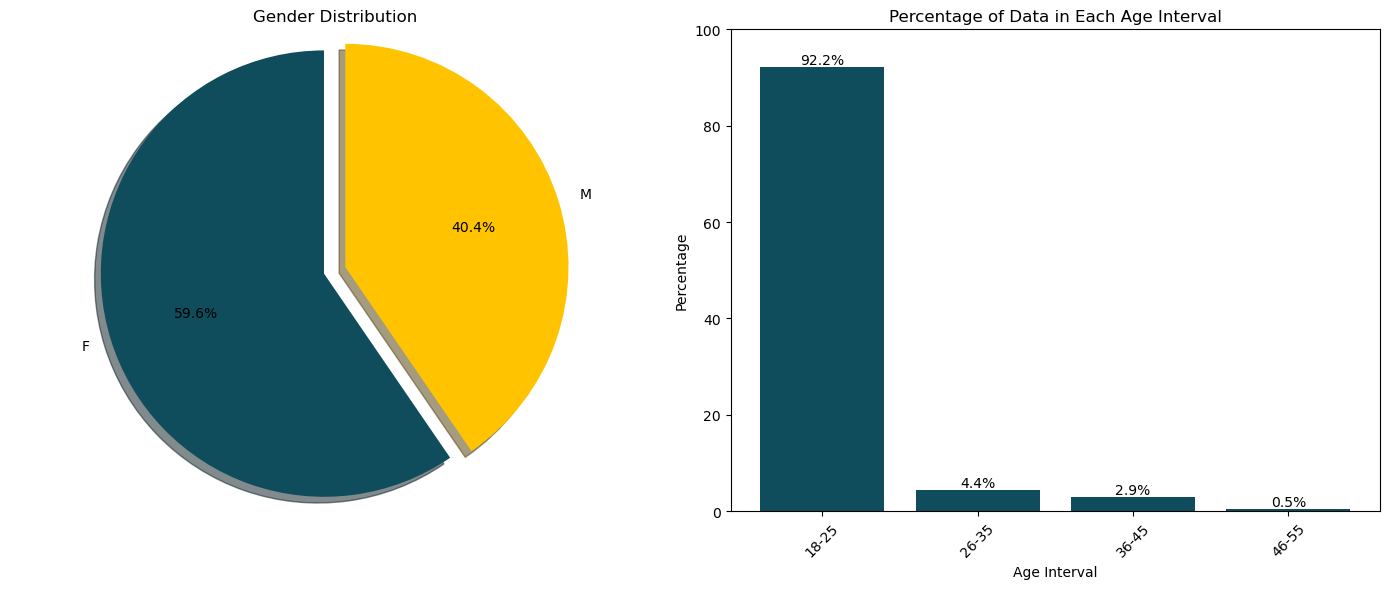

In [11]:
# Calculate the percentage for each age interval
interval_counts = df['Age'].value_counts()
total_count = interval_counts.sum()
percentages = (interval_counts / total_count) * 100

# Calculate the count of each gender
gender_counts = df['Gender'].value_counts()

# Create a figure with two subplots: bar chart and pie chart
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(14, 6))

# Pie chart
labels = gender_counts.index
sizes = gender_counts.values
colors = ["#0f4c5c", "#FFC300"]
explode = (0, 0.1)  # Explode the second slice (Female) for emphasis

ax2.pie(sizes, labels=labels, colors=colors, explode=explode, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
ax2.set_title("Gender Distribution")

# Bar chart
bars = ax1.bar(percentages.index, percentages.values, color='#0f4c5c')
ax1.set_xlabel('Age Interval')
ax1.set_ylabel('Percentage')
ax1.set_title('Percentage of Data in Each Age Interval')
ax1.set_ylim(0, 100)  # Set the y-axis limits to 0-100 for percentage
ax1.set_xticks(percentages.index)
ax1.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

# Add labels to the bar chart
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1f}%', ha='center', va='bottom')


plt.tight_layout()  # Adjust spacing between subplots
plt.show()


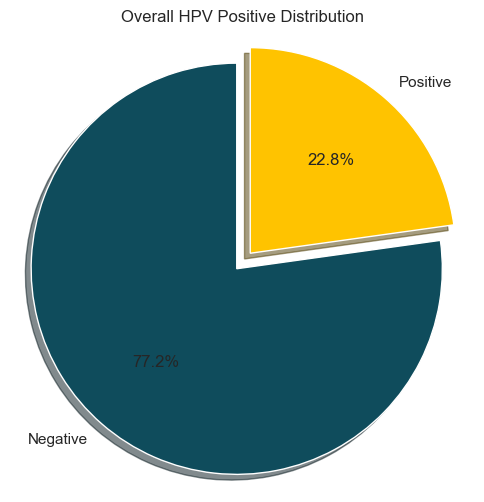

In [12]:
# Calculate the count of each OverallHPVPositive category
hpv_counts = df['OverallHPVPositive'].value_counts()

# Set the theme
sns.set_theme(style="whitegrid")

# Create a figure with a single subplot for the pie chart
fig, ax = plt.subplots(figsize=(6, 6))

# Map category labels
labels = ["Negative", "Positive"]
sizes = hpv_counts.values
colors = ["#0f4c5c", "#FFC300"]
explode = (0, 0.1)  # Explode the second slice (Positive) for emphasis

ax.pie(sizes, labels=labels, colors=colors, explode=explode, autopct='%1.1f%%',
       shadow=True, startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
ax.set_title("Overall HPV Positive Distribution")

plt.show()


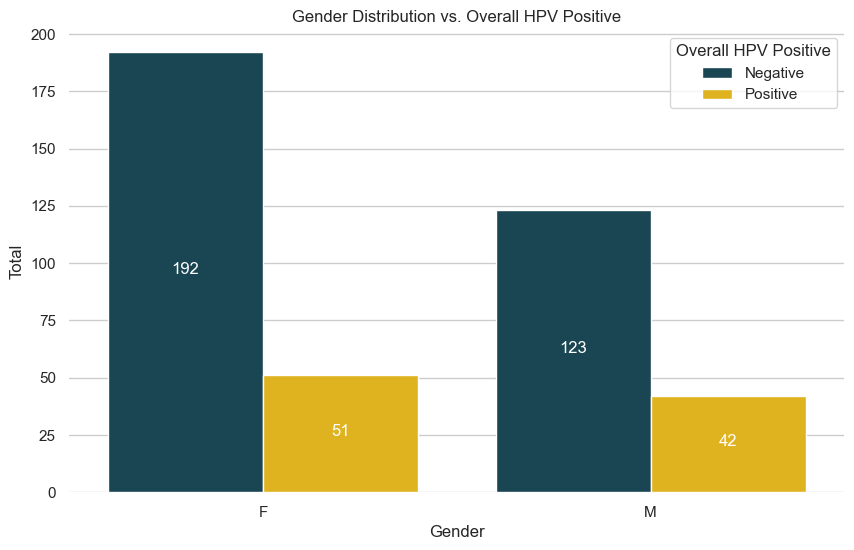

In [13]:
# Set the theme
sns.set_theme(style="whitegrid")

# Plotting the bar chart
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    data=df,
    x="Gender",
    hue="OverallHPVPositive",
    palette=["#0f4c5c", "#FFC300"]
)
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Gender Distribution vs. Overall HPV Positive")

# Update the legend labels
legend_labels = ["Negative", "Positive"]
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, legend_labels, title="Overall HPV Positive", loc="upper right")

ax.set_ylabel("Total")

# Add labels to the bars
for container in ax.containers:
    ax.bar_label(container, label_type="center", padding=2, size=12, color="white")

sns.despine(left=True, bottom=True)
plt.show()


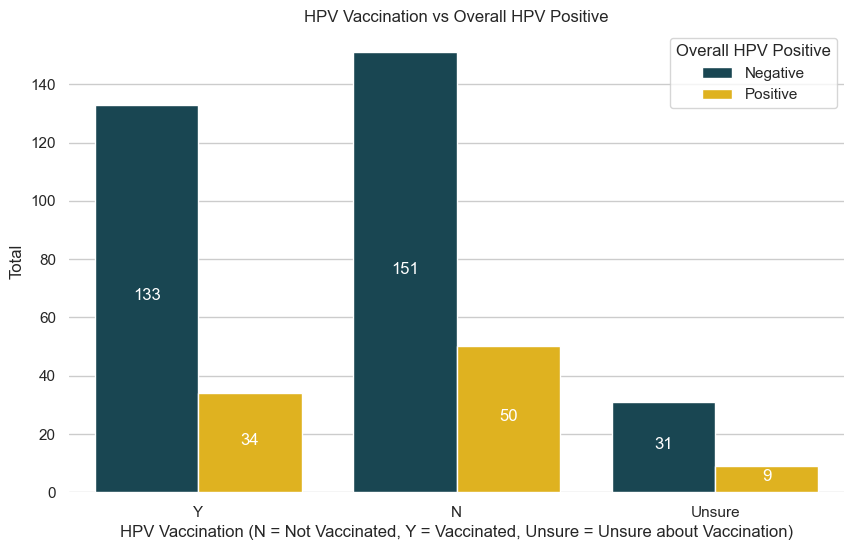

In [14]:
# Set the theme
sns.set_theme(style="whitegrid")

# Plotting the bar chart
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    data=df,
    x="HPVVaccination",
    hue="OverallHPVPositive",
    palette=["#0f4c5c", "#FFC300"]
)
plt.xlabel("HPV Vaccination (N = Not Vaccinated, Y = Vaccinated, Unsure = Unsure about Vaccination)")
plt.ylabel("Count")
plt.title("HPV Vaccination vs Overall HPV Positive")

# Update the legend labels
legend_labels = ["Negative", "Positive"]
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, legend_labels, title="Overall HPV Positive", loc="upper right")

ax.set_ylabel("Total")

# Add labels to the bars
for container in ax.containers:
    ax.bar_label(container, label_type="center", padding=2, size=12, color="white")

sns.despine(left=True, bottom=True)
plt.show()


C:\Users\arash\AppData\Local\Temp\ipykernel_14796\504390436.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tick_labels)


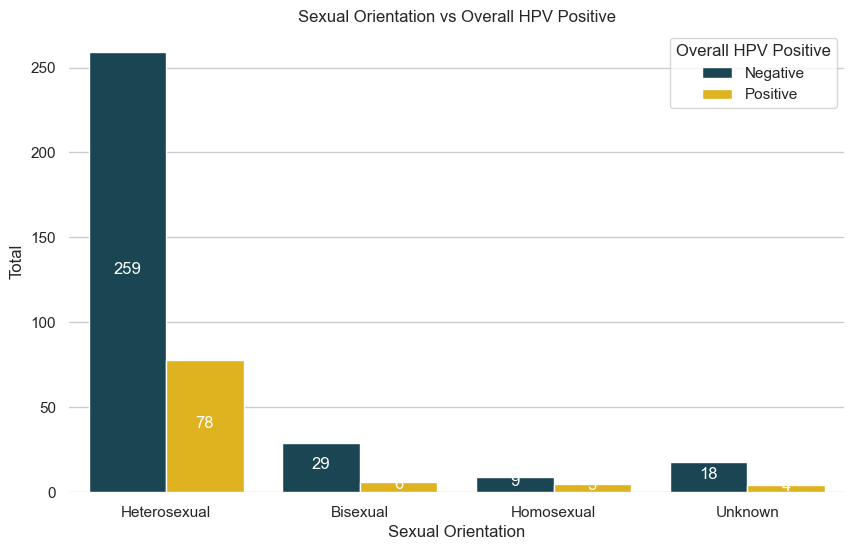

In [15]:
# Set the theme
sns.set_theme(style="whitegrid")

# Plotting the bar chart
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    data=df,
    x="SexualOrientation",
    hue="OverallHPVPositive",
    palette=["#0f4c5c", "#FFC300"]
)
plt.xlabel("Sexual Orientation")
plt.ylabel("Count")
plt.title("Sexual Orientation vs Overall HPV Positive")

# Update the legend labels
legend_labels = ["Negative", "Positive"]
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, legend_labels, title="Overall HPV Positive", loc="upper right")

ax.set_ylabel("Total")

# Add labels to the bars
for container in ax.containers:
    ax.bar_label(container, label_type="center", padding=2, size=12, color="white")

# Generate and set custom x-axis labels
tick_labels = df["SexualOrientation"].unique()
ax.set_xticklabels(tick_labels)

sns.despine(left=True, bottom=True)
plt.show()


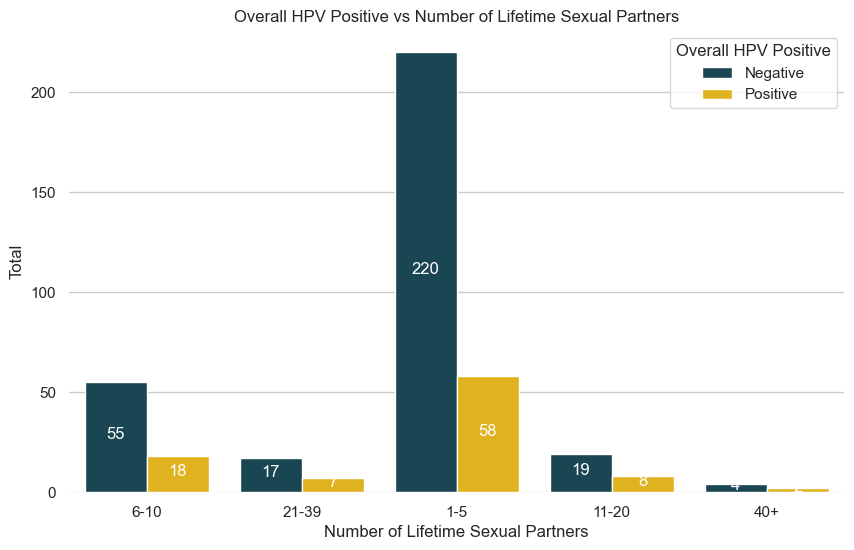

In [16]:
# Set the theme
sns.set_theme(style="whitegrid")

# Plotting the bar chart
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    data=df,
    x="NoofLifetimeSexualPartners",
    hue="OverallHPVPositive",
    palette=["#0f4c5c", "#FFC300"]
)
plt.xlabel("Number of Lifetime Sexual Partners")
plt.ylabel("Count")
plt.title("Overall HPV Positive vs Number of Lifetime Sexual Partners")

# Update the legend labels
legend_labels = ["Negative", "Positive"]
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, legend_labels, title="Overall HPV Positive", loc="upper right")

ax.set_ylabel("Total")

# Add labels to the bars
for container in ax.containers:
    ax.bar_label(container, label_type="center", padding=2, size=12, color="white")

sns.despine(left=True, bottom=True)
plt.show()


C:\Users\arash\AppData\Local\Temp\ipykernel_14796\1724795750.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tick_labels)


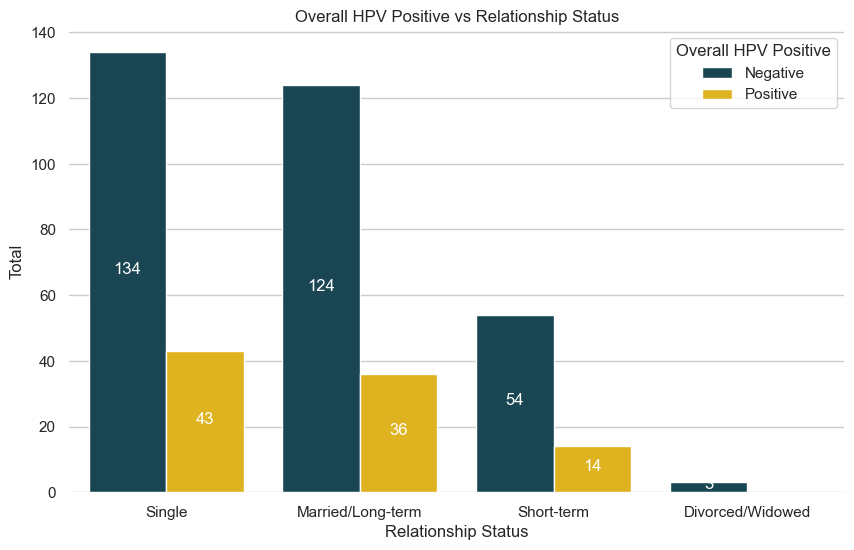

In [17]:
# Set the theme
sns.set_theme(style="whitegrid")

# Plotting the bar chart
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    data=df,
    x="RelationshipStatus",
    hue="OverallHPVPositive",
    palette=["#0f4c5c", "#FFC300"]
)
plt.xlabel("Relationship Status")
plt.ylabel("Count")
plt.title("Overall HPV Positive vs Relationship Status")

# Update the legend labels
legend_labels = ["Negative", "Positive"]
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, legend_labels, title="Overall HPV Positive", loc="upper right")

ax.set_ylabel("Total")

# Add labels to the bars
for container in ax.containers:
    ax.bar_label(container, label_type="center", padding=2, size=12, color="white")

# Generate and set custom x-axis labels
tick_labels = df["RelationshipStatus"].unique()
ax.set_xticklabels(tick_labels)

sns.despine(left=True, bottom=True)
plt.show()


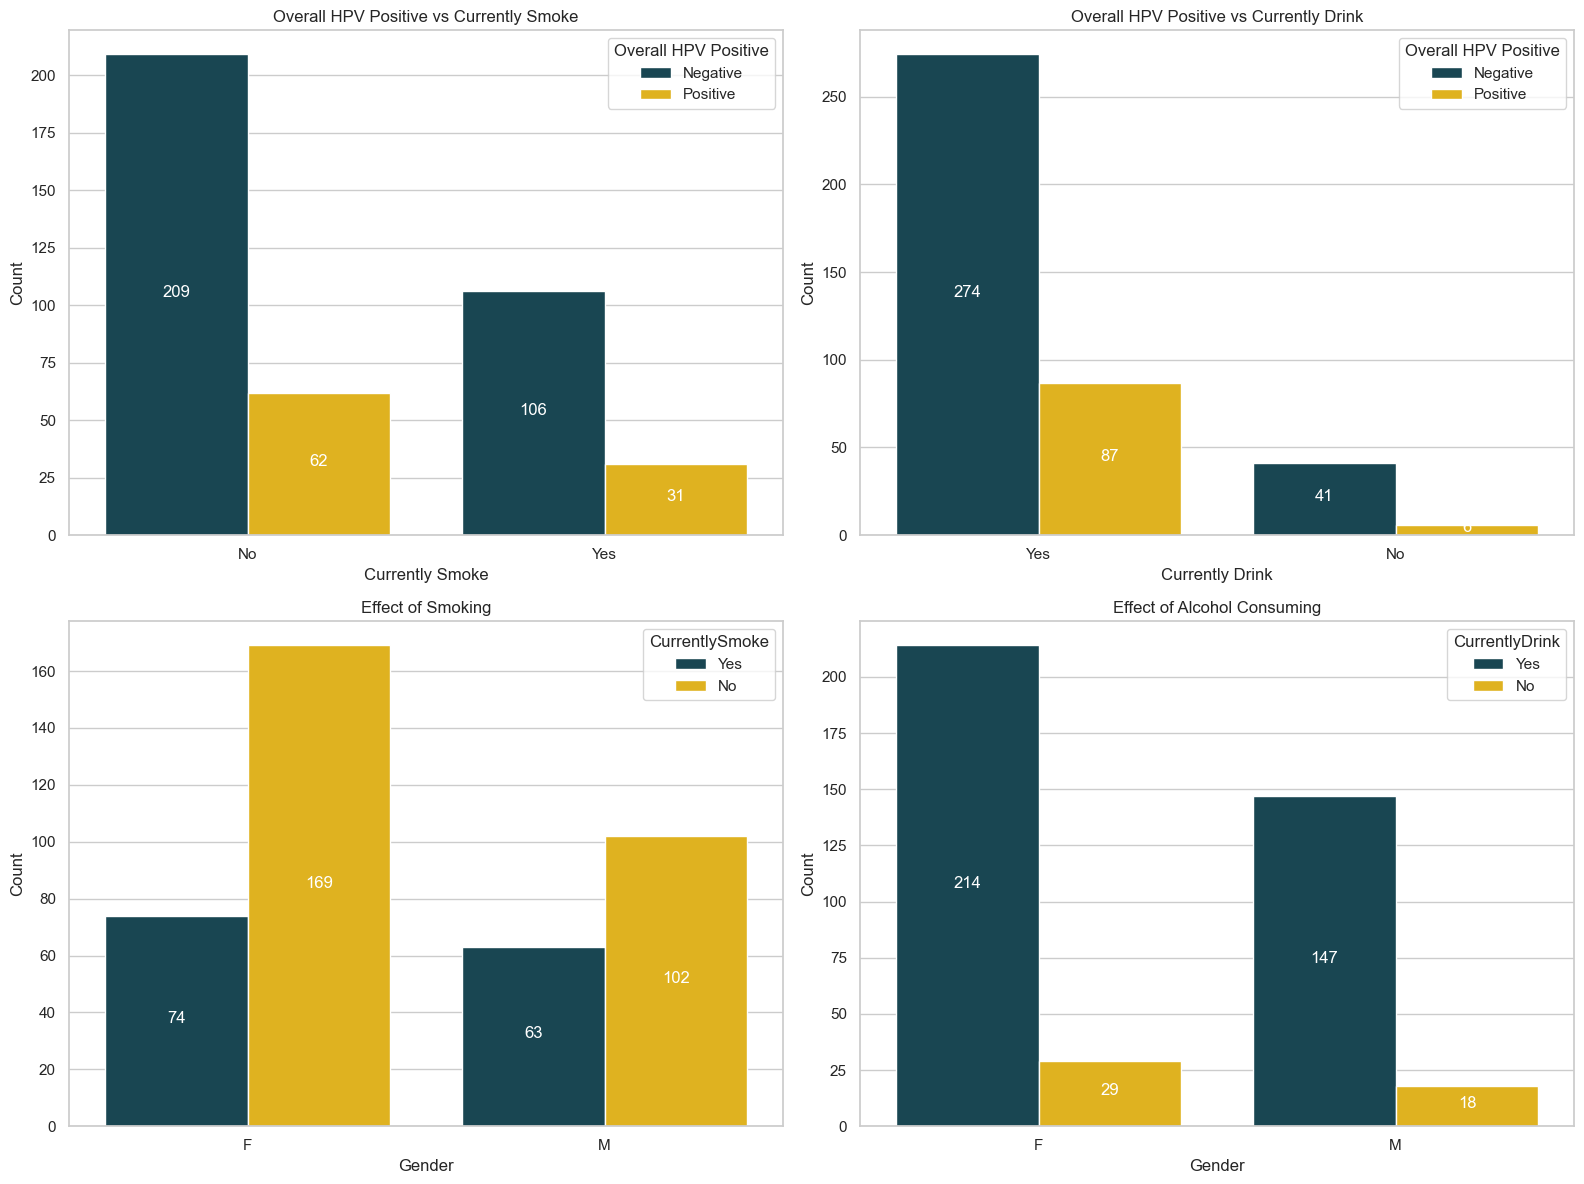

In [18]:
# Set the theme
sns.set_theme(style="whitegrid")

# Create a figure with four subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Plotting the bar chart for CurrentlySmoke
sns.countplot(
    data=df,
    x="CurrentlySmoke",
    hue="OverallHPVPositive",
    palette=["#0f4c5c", "#FFC300"],
    ax=axs[0, 0]
)
axs[0, 0].set_xlabel("Currently Smoke")
axs[0, 0].set_ylabel("Count")
axs[0, 0].set_title("Overall HPV Positive vs Currently Smoke")

# Update the legend labels
legend_labels = ["Negative", "Positive"]
handles, _ = axs[0, 0].get_legend_handles_labels()
axs[0, 0].legend(handles, legend_labels, title="Overall HPV Positive", loc="upper right")

# Add labels to the bars
for container in axs[0, 0].containers:
    axs[0, 0].bar_label(container, label_type="center", padding=2, size=12, color="white")

# Plotting the bar chart for CurrentlyDrink
sns.countplot(
    data=df,
    x="CurrentlyDrink",
    hue="OverallHPVPositive",
    palette=["#0f4c5c", "#FFC300"],
    ax=axs[0, 1]
)
axs[0, 1].set_xlabel("Currently Drink")
axs[0, 1].set_ylabel("Count")
axs[0, 1].set_title("Overall HPV Positive vs Currently Drink")

# Update the legend labels
legend_labels = ["Negative", "Positive"]
handles, _ = axs[0, 1].get_legend_handles_labels()
axs[0, 1].legend(handles, legend_labels, title="Overall HPV Positive", loc="upper right")

# Add labels to the bars
for container in axs[0, 1].containers:
    axs[0, 1].bar_label(container, label_type="center", padding=2, size=12, color="white")

# Plotting the bar chart for CurrentlySmoke and Gender
sns.countplot(
    data=df,
    x="Gender",
    hue="CurrentlySmoke",
    hue_order=["Yes", "No"],
    ax=axs[1, 0],
    palette=["#0f4c5c", "#FFC300"]
)
axs[1, 0].set_xlabel("Gender")
axs[1, 0].set_ylabel("Count")
axs[1, 0].set_title("Effect of Smoking")

# Add labels to the bars
for container in axs[1, 0].containers:
    axs[1, 0].bar_label(container, label_type="center", padding=2, size=12, color="white")

# Plotting the bar chart for CurrentlyDrink and Gender
sns.countplot(
    data=df,
    x="Gender",
    hue="CurrentlyDrink",
    hue_order=["Yes", "No"],
    ax=axs[1, 1],
    palette=["#0f4c5c", "#FFC300"]
)
axs[1, 1].set_xlabel("Gender")
axs[1, 1].set_ylabel("Count")
axs[1, 1].set_title("Effect of Alcohol Consuming")

# Add labels to the bars
for container in axs[1, 1].containers:
    axs[1, 1].bar_label(container, label_type="center", padding=2, size=12, color="white")

plt.tight_layout()
plt.show()


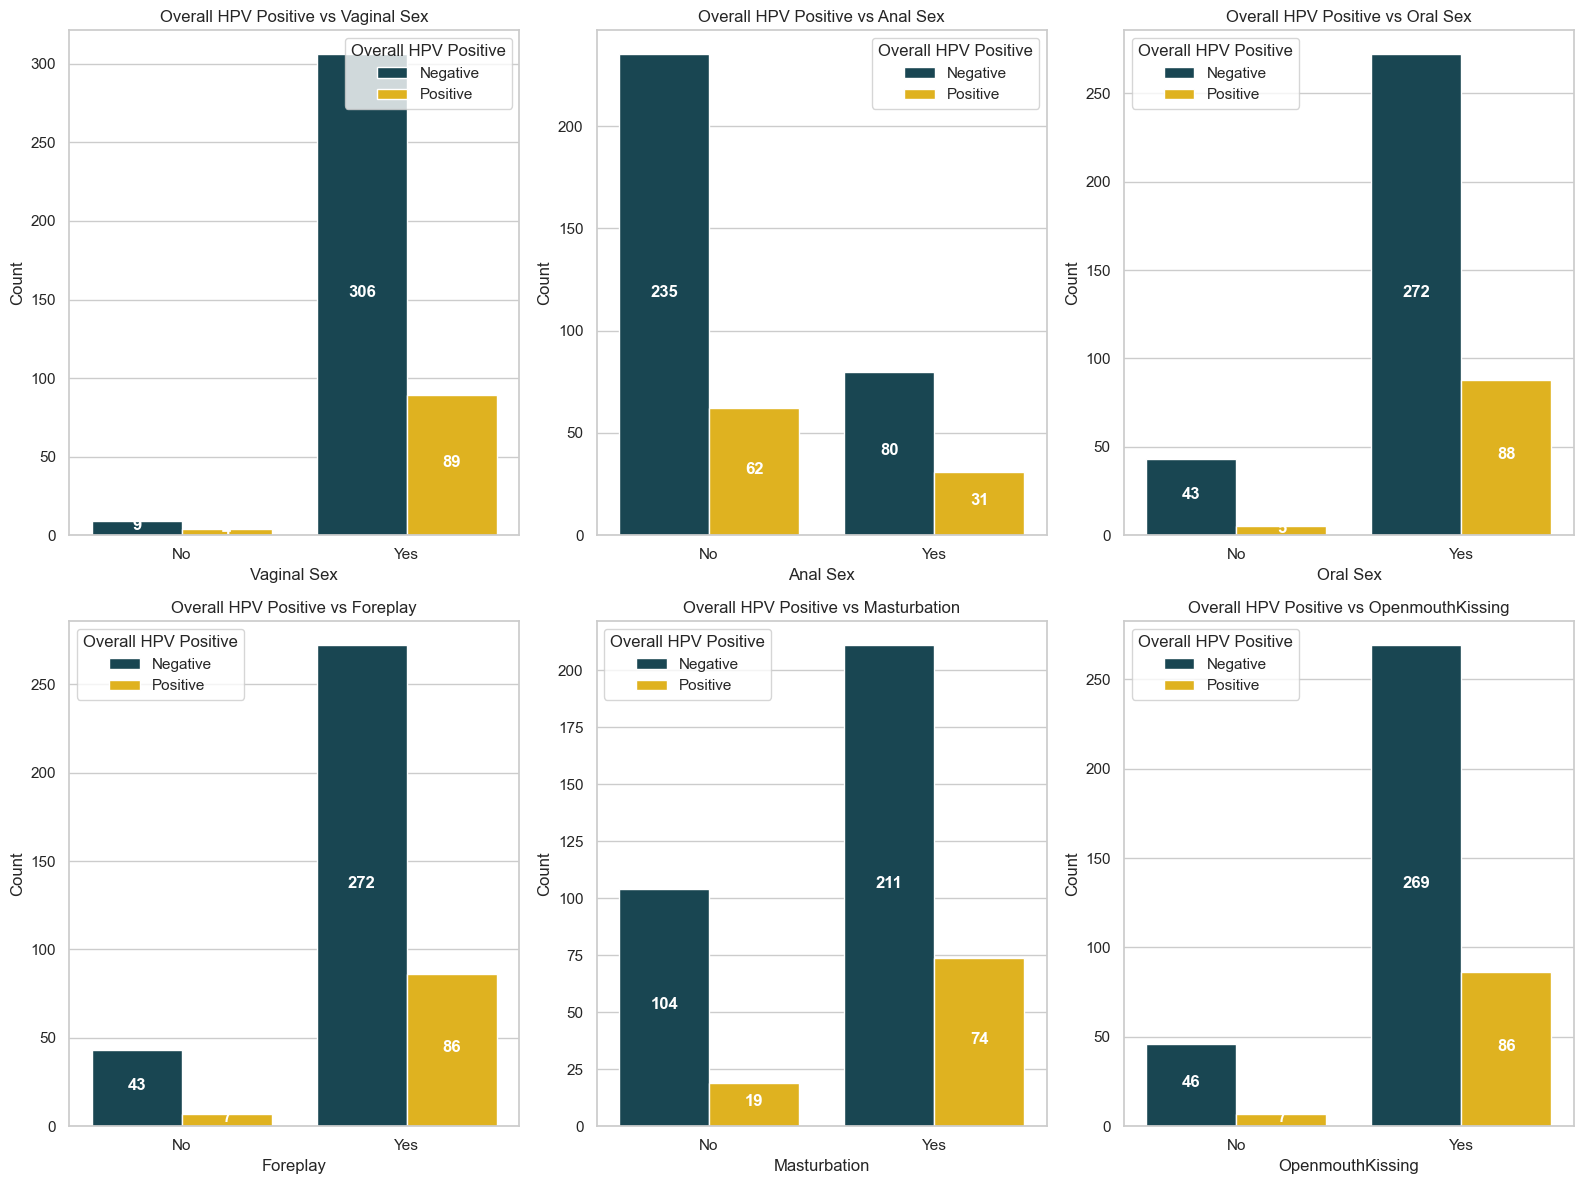

In [19]:
sns.set_theme(style="whitegrid")

fig, axs = plt.subplots(2, 3, figsize=(16, 12))

label_mappings = {0: "No", 1: "Yes"}
palette = ["#0f4c5c", "#FFC300"]

features = [
    ("vaginal_sex", axs[0, 0], "upper right", "Vaginal Sex"),
    ("anal_sex", axs[0, 1], "upper right", "Anal Sex"),
    ("oral_sex", axs[0, 2], "upper left", "Oral Sex"),
    ("foreplay", axs[1, 0], "upper left", "Foreplay"),
    ("masturbation", axs[1, 1], "upper left", "Masturbation"),
    ("OpenmouthKissing", axs[1, 2], "upper left", "OpenmouthKissing")
]

for feature, ax, legend_loc, nice_name in features:
    sns.countplot(
        data=df,
        x=feature,
        hue="OverallHPVPositive",
        palette=palette,
        ax=ax
    )

    ax.set_xticks([0, 1])
    ax.set_xticklabels([label_mappings[0], label_mappings[1]])

    ax.set_xlabel(nice_name)
    ax.set_ylabel("Count")
    ax.set_title(f"Overall HPV Positive vs {nice_name}")

    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles, ["Negative", "Positive"], title="Overall HPV Positive", loc=legend_loc)

    for container in ax.containers:
        ax.bar_label(container, label_type="center", padding=2, size=12, color="white", fontweight="bold")

plt.tight_layout()
plt.show()


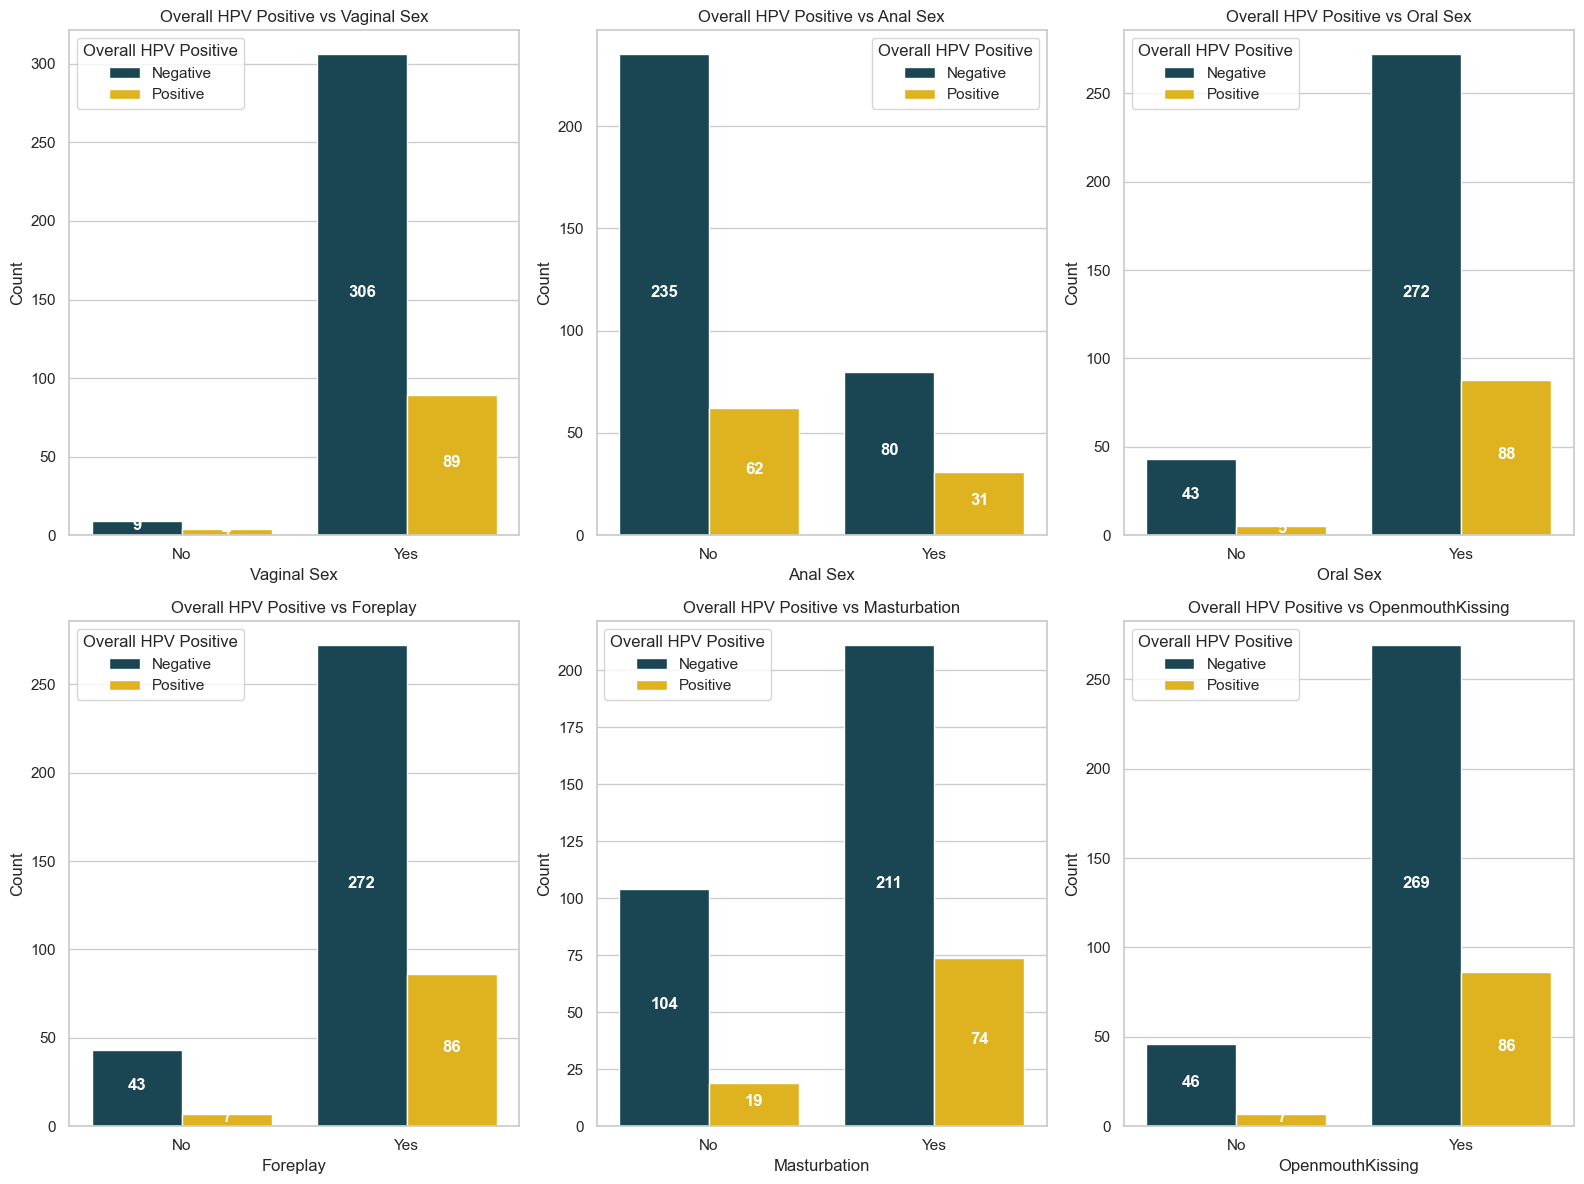

In [20]:
sns.set_theme(style="whitegrid")

fig, axs = plt.subplots(2, 3, figsize=(16, 12))

palette = ["#0f4c5c", "#FFC300"]
legend_labels = ["Negative", "Positive"]

plots = [
    ("vaginal_sex", axs[0, 0], "upper left", "Vaginal Sex"),
    ("anal_sex", axs[0, 1], "upper right", "Anal Sex"),
    ("oral_sex", axs[0, 2], "upper left", "Oral Sex"),
    ("foreplay", axs[1, 0], "upper left", "Foreplay"),
    ("masturbation", axs[1, 1], "upper left", "Masturbation"),
    ("OpenmouthKissing", axs[1, 2], "upper left", "OpenmouthKissing")
]

for col, ax, legend_loc, label in plots:
    sns.countplot(
        data=df,
        x=col,
        hue="OverallHPVPositive",
        palette=palette,
        ax=ax
    )

    ax.set_xlabel(label)
    ax.set_ylabel("Count")
    ax.set_title(f"Overall HPV Positive vs {label}")

    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles, legend_labels, title="Overall HPV Positive", loc=legend_loc)

    ax.set_xticks([0, 1])
    ax.set_xticklabels(["No", "Yes"])

    for container in ax.containers:
        ax.bar_label(container, label_type="center", padding=2, size=12, color="white", fontweight="bold")

plt.tight_layout()
plt.show()


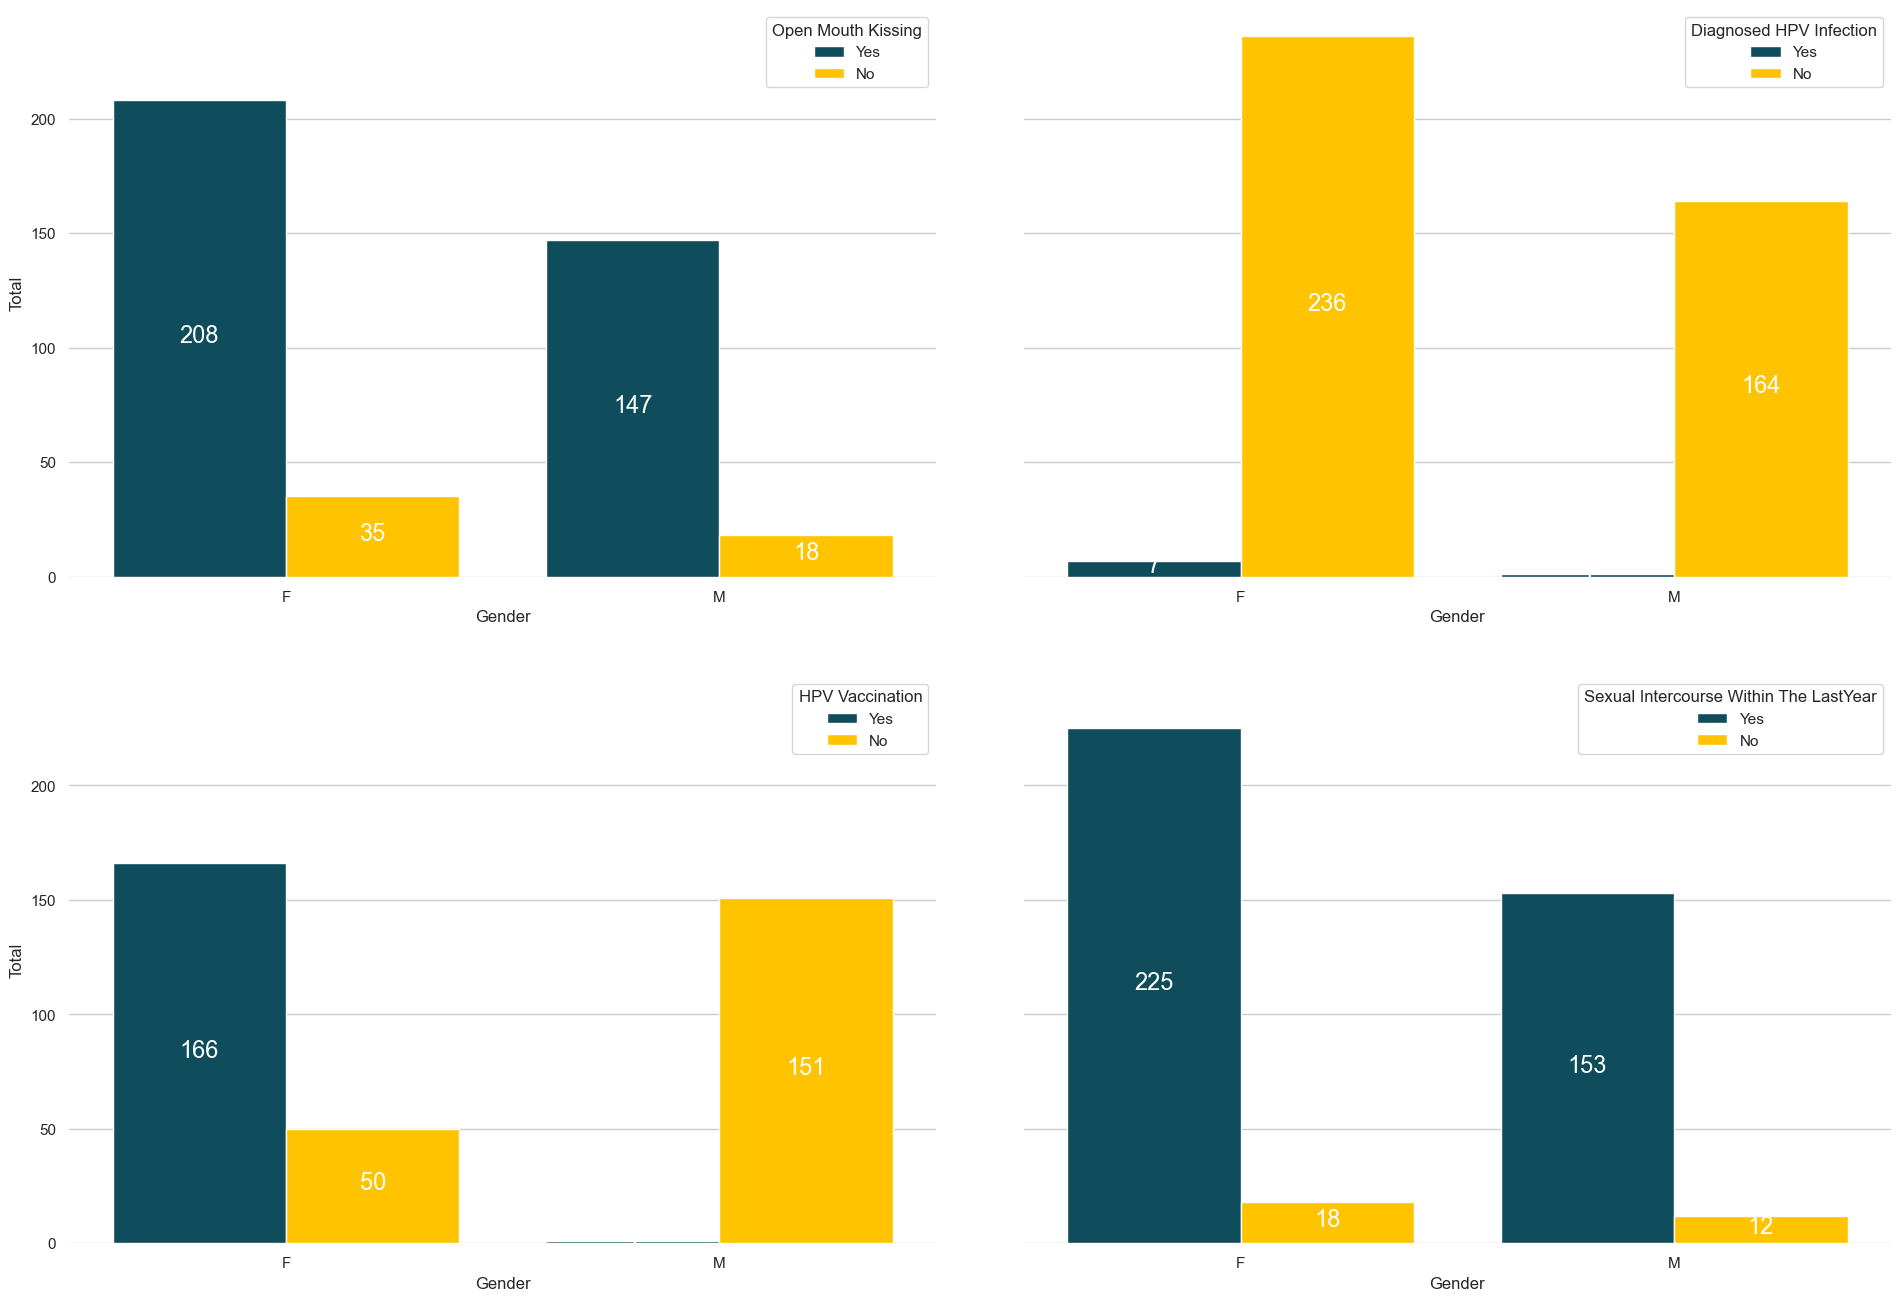

In [21]:
_, axs = plt.subplots(2,2,figsize=(20,14),sharex=False,sharey=True)
plt.tight_layout(pad=4.0)

data_temp_pos = df.copy()
sns.countplot(data=data_temp_pos,x="Gender",hue="OpenmouthKissing",hue_order=["Y","N"],ax=axs[0,0],palette=["#0f4c5c","#FFC300"],saturation=1)
axs[0,0].set_ylabel("Total")
axs[0,0].legend(title="Open Mouth Kissing",loc="upper right",labels=["Yes", "No"])
for container in axs[0,0].containers:
    axs[0,0].bar_label(container,label_type="center",padding=2,size=17,color="white",rotation=0)

sns.countplot(data=data_temp_pos,x="Gender",hue="DiagnosedHPVInfection",hue_order=["Y","N"],ax=axs[0,1],palette=["#0f4c5c","#FFC300"],saturation=1)
axs[0,1].set_ylabel("Total")
axs[0,1].legend(title="Diagnosed HPV Infection",loc="upper right",labels=["Yes", "No"])
for container in axs[0,1].containers:
    axs[0,1].bar_label(container,label_type="center",padding=2,size=17,color="white",rotation=0)

sns.countplot(data=data_temp_pos,x="Gender",hue="HPVVaccination",hue_order=["Y","N"],ax=axs[1,0],palette=["#0f4c5c","#FFC300"],saturation=1)
axs[1,0].set_ylabel("Total")
axs[1,0].legend(title="HPV Vaccination",loc="upper right",labels=["Yes", "No"])
for container in axs[1,0].containers:
    axs[1,0].bar_label(container,label_type="center",padding=2,size=17,color="white",rotation=0)

sns.countplot(data=data_temp_pos,x="Gender",hue="SexualIntercourseWithinTheLastYear",hue_order=["Y","N"],ax=axs[1,1],palette=["#0f4c5c","#FFC300"],saturation=1)
axs[1,1].set_ylabel("Total")
axs[1,1].legend(title="Sexual Intercourse Within The LastYear",loc="upper right",labels=["Yes", "No"])
for container in axs[1,1].containers:
    axs[1,1].bar_label(container,label_type="center",padding=2,size=17,color="white",rotation=0)

sns.despine(left=True, bottom=True)
plt.show()

## Baseline Risk Modelling with Logistic Regression

At this stage, we establish a transparent and interpretable baseline model to assess HPV infection risk.
Given the strong class imbalance and the screening-oriented nature of the task, Logistic Regression is
used as the primary modelling approach.

Rather than optimising for maximum accuracy, the focus is on:
- Robust evaluation under class imbalance
- Probability-based risk estimation
- Clear interpretation of model behaviour and limitations

Class imbalance is handled via class weighting, and performance is evaluated using metrics
that are appropriate for imbalanced healthcare data, including ROC AUC and Average Precision.


In [22]:
processed_data = processed_data.fillna(0)


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    classification_report,
    confusion_matrix
)

# Define features and target
X = processed_data.drop("target", axis=1)
y = processed_data["target"]

# Sanity check
assert X.isna().sum().sum() == 0, "Missing values detected in feature matrix"

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Baseline Logistic Regression with class weighting
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    solver="liblinear"
)

log_reg.fit(X_train, y_train)

# Predicted probabilities and labels
y_prob = log_reg.predict_proba(X_test)[:, 1]
y_pred = log_reg.predict(X_test)

# Evaluation metrics
roc_auc = roc_auc_score(y_test, y_prob)
avg_precision = average_precision_score(y_test, y_prob)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, digits=3)

roc_auc, avg_precision, conf_matrix, report


(0.4795321637426901,
 0.30870430526161236,
 array([[32, 31],
        [13,  6]], dtype=int64),
 '              precision    recall  f1-score   support\n\n           0      0.711     0.508     0.593        63\n           1      0.162     0.316     0.214        19\n\n    accuracy                          0.463        82\n   macro avg      0.437     0.412     0.403        82\nweighted avg      0.584     0.463     0.505        82\n')

## Baseline Model Findings and Limitations

The baseline Logistic Regression model provides an important reference point for understanding the
predictive limits of this dataset. Despite applying class weighting to address the strong imbalance
between HPV positive and negative cases, the model demonstrates only weak discriminative ability.

The ROC AUC score is close to 0.5, indicating performance only marginally better than random guessing.
This suggests that the available lifestyle and self-reported behavioural variables contain limited
signal for reliably separating HPV positive cases from negative ones.

Recall for the HPV positive class remains low at the default decision threshold, meaning that a
substantial proportion of true positive cases are missed. While class weighting improves sensitivity
relative to an unweighted model, it is insufficient on its own to support screening-level decision
making.

These results highlight several structural constraints of the dataset: significant noise in
self-reported responses, limited sample size for positive cases, and the absence of strong clinical
predictors. Importantly, this outcome is not interpreted as model failure, but as an accurate
reflection of real-world data limitations.

As a result, this baseline model is not suitable for diagnostic or rule-in use. However, it provides
a transparent foundation for further analysis, particularly threshold tuning and recall-focused
evaluation, which are more aligned with exploratory risk assessment and screening support.


---

## Decision Threshold Analysis for Screening-Oriented Use

Given the weak discriminative performance of the baseline model at the default threshold (0.5),
we examine alternative decision thresholds to assess whether the model can be repurposed for
screening-level risk identification.

In screening contexts, higher recall is often prioritised over precision, as the cost of
missing true positive cases may outweigh the cost of increased false positives. Therefore,
we evaluate multiple probability thresholds and analyse the resulting trade-offs between
recall, precision, and false positive rates.


In [25]:

thresholds = [0.5, 0.3, 0.2]

results = []

for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)

    report = classification_report(y_test, y_pred_t, output_dict=True)
    cm = confusion_matrix(y_test, y_pred_t)

    results.append({
        "threshold": t,
        "precision_pos": report["1"]["precision"],
        "recall_pos": report["1"]["recall"],
        "f1_pos": report["1"]["f1-score"],
        "false_positives": cm[0, 1],
        "true_positives": cm[1, 1],
        "false_negatives": cm[1, 0]
    })

threshold_results = pd.DataFrame(results)
threshold_results


,threshold,precision_pos,recall_pos,f1_pos,false_positives,true_positives,false_negatives
0,0.5,0.162162,0.315789,0.214286,31,6,13
1,0.3,0.242424,0.842105,0.376471,50,16,3
2,0.2,0.239437,0.894737,0.377778,54,17,2


## Threshold Trade-Off Interpretation

Lowering the decision threshold substantially increases recall for HPV positive cases,
confirming that the model can identify a greater proportion of at-risk individuals when
used in a screening-oriented configuration.

However, this improvement comes at the cost of increased false positives and reduced
precision. This trade-off is expected and acceptable in exploratory screening contexts,
but would be inappropriate for confirmatory or diagnostic use.

These findings reinforce the importance of threshold tuning in imbalanced healthcare
datasets, where default classification cut-offs may fail to align with real-world
decision objectives.


---

## Threshold Analysis Results and Decision Implications

The results clearly demonstrate that the default classification threshold of 0.5 is not
appropriate for screening-oriented HPV risk assessment. At this threshold, the model
identifies only a small fraction of true positive cases, missing the majority of individuals
who are HPV positive.

Lowering the decision threshold leads to a substantial improvement in recall for the
HPV positive class. At a threshold of 0.3, recall increases to over 84 percent, while at 0.2
it approaches 90 percent. This confirms that the model is capable of detecting most
positive cases when configured for sensitivity rather than precision.

However, this improvement comes with a significant increase in false positives.
As the threshold decreases, the number of HPV negative individuals incorrectly flagged
as positive rises sharply. Precision remains low across all thresholds, reflecting the
strong overlap between positive and negative cases in feature space.

From a decision perspective, this trade-off is expected and acceptable in exploratory
screening contexts, where the primary objective is to minimise missed positive cases
rather than to provide definitive diagnoses. In contrast, these results indicate that the
model is unsuitable for confirmatory or rule-in decision making, regardless of threshold.

Overall, threshold tuning transforms the baseline model from a weak classifier into a
potential screening support tool, provided its limitations are clearly acknowledged and
its outputs are used as probabilistic risk indicators rather than binary clinical decisions.


---


## Final Limitations and Recommendations

This project demonstrates the challenges of building HPV risk models using real-world,
self-reported healthcare and lifestyle data. Despite applying appropriate preprocessing,
class weighting, and threshold tuning, the model exhibits limited discriminative power,
primarily due to structural constraints in the dataset.

Key limitations include strong class imbalance, substantial noise in behavioural variables,
and the absence of clinically definitive predictors. As a result, the model is not suitable
for diagnostic or confirmatory decision making, regardless of threshold configuration.

However, threshold analysis shows that the model can be repurposed as a screening-level
support tool. By lowering the decision threshold, recall for HPV positive cases increases
substantially, allowing the identification of most at-risk individuals at the expense of
higher false positive rates. This trade-off is acceptable in exploratory screening contexts,
where sensitivity is prioritised over precision.

It is important to emphasise that model outputs should be interpreted as probabilistic risk
signals rather than binary clinical decisions. Any real-world use would require downstream
clinical validation, additional patient context, and integration with medical expertise.

Future improvements would require higher-quality clinical features, longitudinal data,
or confirmed laboratory results to meaningfully enhance predictive performance. Until such
data are available, this modelling approach should remain limited to analytical exploration
and decision-support experimentation rather than clinical deployment.
